In [1]:
# Things to be done
    # Temperatures at experimental data points
    # Inlet concentrations of gases
    # Inlet pressure and reactor volume for experimental data
    # Import experimental data

In [10]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np
import time
import cantera as ct

In [11]:
# Import mechanism
gas = ct.Solution('n-HeptaneMech.cti')

In [12]:
reactorTemperature = 500
reactorPressure = 106658
concentrations = {'NC7H16': 0.005, 'O2': 0.022, 'HE': 0.775}
gas.TPX = reactorTemperature, reactorPressure, concentrations 


residenceTime = 2
reactorVolume = 95*(1e-2)**3 #m3

 
pressureValveCoefficient = 0.01


maxPressureRiseAllowed = 0.01

In [14]:
maxSimulationTime = 50

In [15]:
fuelAirMixtureTank = ct.Reservoir(gas)
exhaust = ct.Reservoir(gas)

stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)

massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                           downstream=stirredReactor,
                                           mdot=stirredReactor.mass/residenceTime)

pressureRegulator = ct.Valve(upstream=stirredReactor,
                             downstream=exhaust,
                             K=pressureValveCoefficient)

reactorNetwork = ct.ReactorNet([stirredReactor])

In [16]:
# now compile a list of all variables for which we will store data
columnNames = [stirredReactor.component_name(item) for item in range(stirredReactor.n_vars)]
columnNames = ['pressure'] + columnNames

# use the above list to create a DataFrame
timeHistory = pd.DataFrame(columns=columnNames)

In [17]:
# Temperatures at which simulation will be run
T = [500,525,550,575,600,625,650,675,700,725,750,775,800,825,850,875,900,925,950,975,1000,1025,1050,1075]
tempDependence = pd.DataFrame(columns=timeHistory.columns)
tempDependence.index.name = 'Temperature'

In [18]:
# Simulation timer starts
tic = time.time()

# Initialize simulation
t = 0
inletConcentrations = {'NC7H16': 0.005, 'O2': 0.22, 'HE': 0.775}
concentrations = inletConcentrations

for temperature in T:
    #Gas is re-initialized for each simulation
    reactorTemperature = temperature #Units: Kelvin
    reactorPressure = 106658 #Units: Pa
    reactorVolume = 95*(1e-2)**3 #Units: m^3
    gas.TPX = reactorTemperature, reactorPressure, inletConcentrations

    # Data frame is re-initialized for each simulation
    timeHistory = pd.DataFrame(columns=columnNames)
    
    # System is re-initalized for each simulation
    fuelAirMixtureTank = ct.Reservoir(gas)
    exhaust = ct.Reservoir(gas)
    
    # Concentrations from previous simulations used to speed up convergence
    gas.TPX = reactorTemperature, reactorPressure, concentrations
    
    stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)
    massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                               downstream=stirredReactor,
                                               mdot=stirredReactor.mass/residenceTime)
    pressureRegulator = ct.Valve(upstream=stirredReactor, 
                                 downstream=exhaust, 
                                 K=pressureValveCoefficient)
    reactorNetwork = ct.ReactorNet([stirredReactor])
    
    # Isothermal simulations are re-run
    tic = time.time()
    t = 0
    while t < maxSimulationTime:
        t = reactorNetwork.step()
        
    state = np.hstack([stirredReactor.thermo.P, 
                       stirredReactor.mass, 
                       stirredReactor.volume, 
                       stirredReactor.T, 
                       stirredReactor.thermo.X])

    toc = time.time()
    print('Simulation at T={}K took {:3.2f}s to compute'.format(temperature, toc-tic))
    
    concentrations = stirredReactor.thermo.X
    
    # Simulation result is saved
    tempDependence.loc[temperature] = state

Simulation at T=500K took 11.56s to compute
Simulation at T=525K took 11.14s to compute
Simulation at T=550K took 13.79s to compute
Simulation at T=575K took 12.07s to compute
Simulation at T=600K took 8.97s to compute
Simulation at T=625K took 8.46s to compute
Simulation at T=650K took 9.61s to compute
Simulation at T=675K took 12.19s to compute
Simulation at T=700K took 10.61s to compute
Simulation at T=725K took 7.78s to compute
Simulation at T=750K took 6.52s to compute
Simulation at T=775K took 6.34s to compute
Simulation at T=800K took 7.52s to compute
Simulation at T=825K took 8.62s to compute
Simulation at T=850K took 9.32s to compute
Simulation at T=875K took 8.53s to compute
Simulation at T=900K took 8.33s to compute
Simulation at T=925K took 8.31s to compute
Simulation at T=950K took 8.79s to compute
Simulation at T=975K took 8.85s to compute
Simulation at T=1000K took 8.47s to compute
Simulation at T=1025K took 9.69s to compute
Simulation at T=1050K took 8.51s to compute
Si

In [31]:
expData = pd.read_excel('Experimental_data_nheptane_zhang.xlsx')
expData.head()

,Temp,n-heptane,oxygen,CO
0,500,0.004906,0.233085,0.000000
1,525,0.004773,0.229530,0.000000
2,550,0.003780,0.229083,0.000095
3,575,0.003242,0.219728,0.001025
4,600,0.002342,0.214652,0.003514


<IPython.core.display.Javascript object>


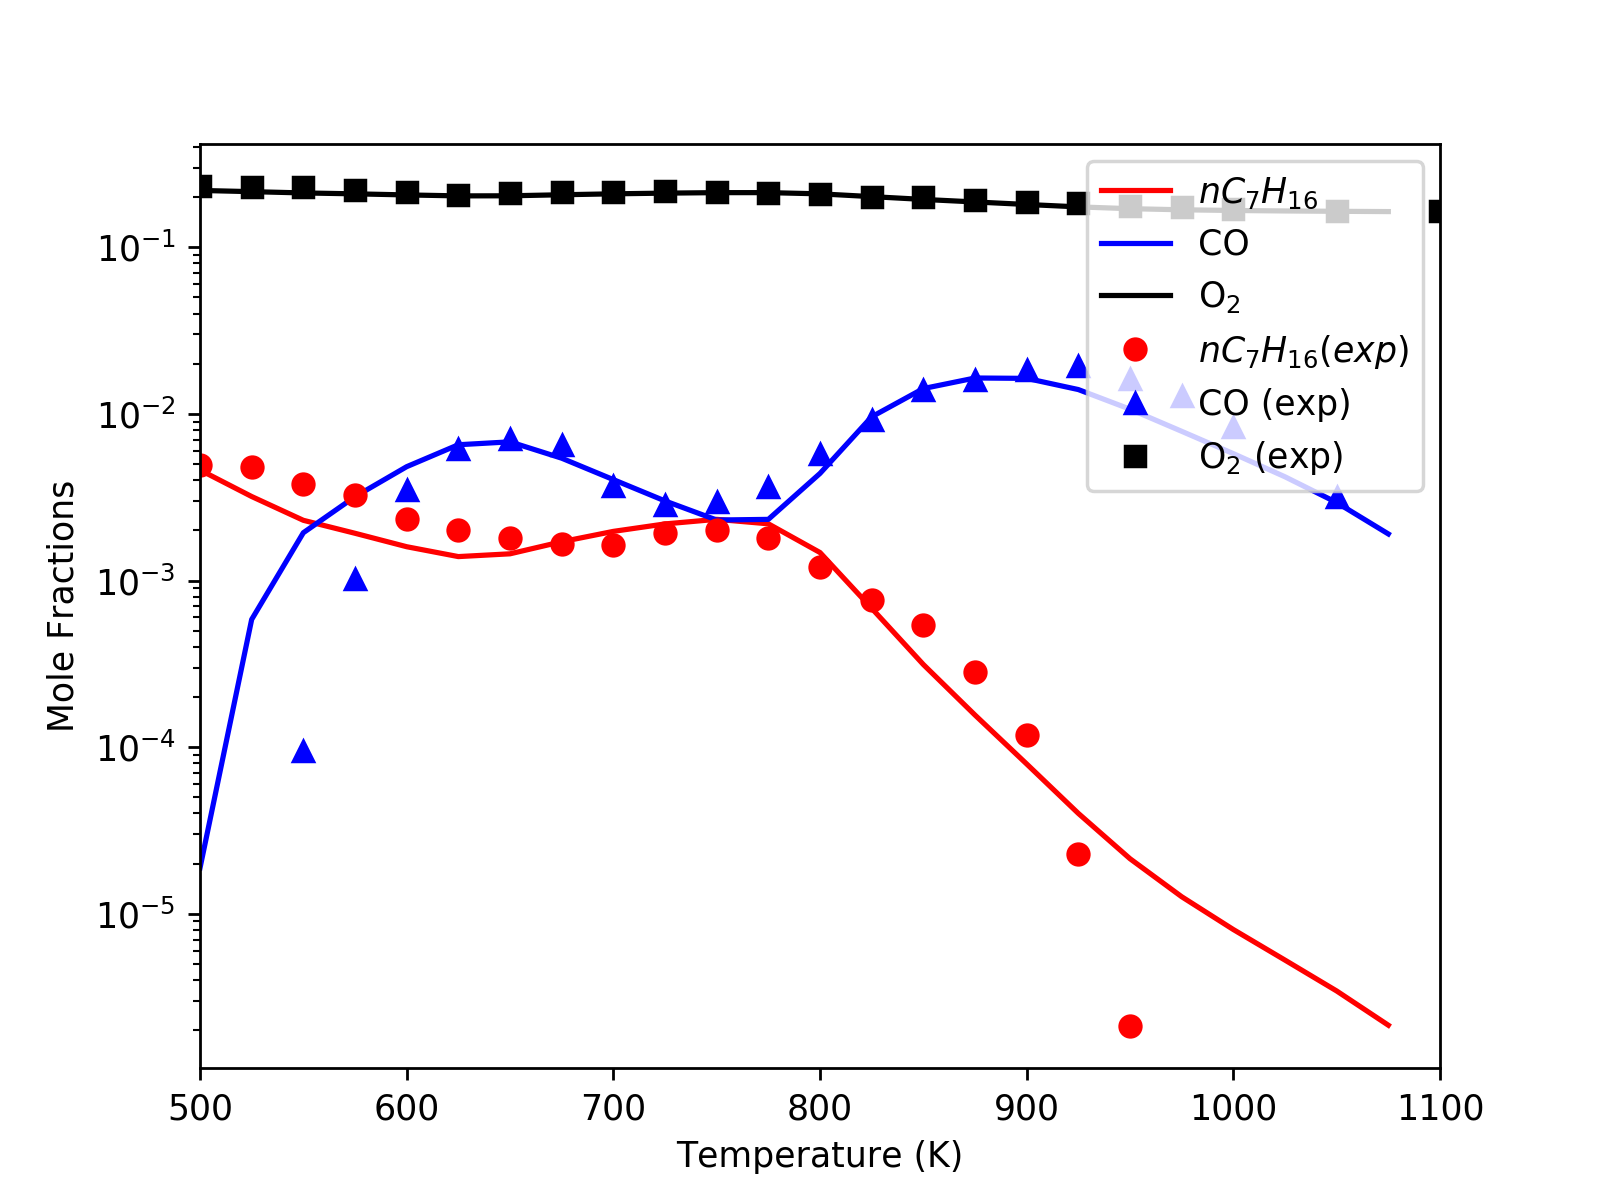

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

plt.figure()
plt.semilogy(tempDependence.index, tempDependence['NC7H16'], 'r-', label=r'$nC_{7}H_{16}$')
plt.semilogy(tempDependence.index, tempDependence['CO'], 'b-', label='CO')
plt.semilogy(tempDependence.index, tempDependence['O2'], 'k-', label='O$_{2}$')


plt.semilogy(expData['Temp'], expData['n-heptane'],'ro', label=r'$nC_{7}H_{16} (exp)$')
plt.semilogy(expData['Temp'], expData['CO'],'b^', label='CO (exp)')
plt.semilogy(expData['Temp'], expData['oxygen'],'ks', label='O$_{2}$ (exp)')

plt.xlabel('Temperature (K)')
plt.ylabel(r'Mole Fractions')



plt.xlim([500,1100])
plt.legend(loc=1);